In [ ]:
# ДЗ
# 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Чтение картинки

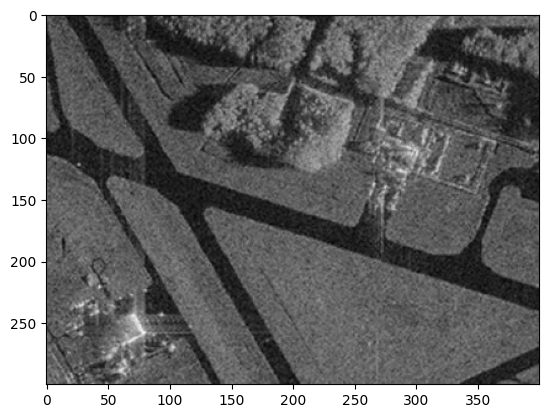

In [3]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")

Гистограмма яркости

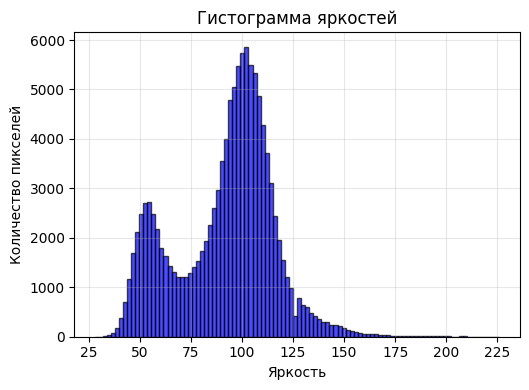

In [4]:
def simple_histogram(image, mask=None, title="Гистограмма яркостей"):
    if mask is not None:
        pixels = image[mask > 0]
    else:
        pixels = image.flatten()
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plt.hist(pixels, bins=100, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Яркость')
    plt.ylabel('Количество пикселей')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

simple_histogram(image_gray)

Критерий однородности (отклонение любого пикселя от средней яркости T)

In [5]:
import math
def homo_average(img, mask, point, T):
    av_val = np.mean(img[mask > 0])                                                    
    return abs(av_val - img[point]) <= T
    


Алгоритм разрастания регионов

In [6]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
        
    return mask*255

### 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

In [7]:
def robust_manual_parameter_test(image, seed, test_parameters):
    print("Запуск надежного тестирования параметров...")
    
    results = []
    
    for i, (r, T) in enumerate(test_parameters):
        print(f"\nТестирование {i+1}/{len(test_parameters)}: r={r}, T={T}")
        
        try:
            # Запускаем регионарный рост
            result_mask = region_growing(image, seed, homo_average, r, T)
            area = np.sum(result_mask > 0)
            
            results.append((r, T, result_mask, area))
            
            # Сразу показываем результат
            plt.figure(figsize=(10, 4))
            
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Исходное изображение')
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(result_mask, cmap='gray')
            plt.title(f'r={r}, T={T}\nПлощадь: {area}px')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(image, cmap='gray')
            plt.imshow(result_mask, alpha=0.4, cmap='Reds')
            plt.title('Наложение маски')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Ошибка: {e}")
            results.append((r, T, None, 0))
    
    return results

def quick_visual_test():
    test_parameters = [
        (1, 10),
        (2, 20), 
        (2, 30),
        (2, 35)
    ]
    
    image = image_gray
    seed = (250,250)
    
    return robust_manual_parameter_test(image, seed, test_parameters)

Запуск надежного тестирования параметров...

Тестирование 1/4: r=1, T=10


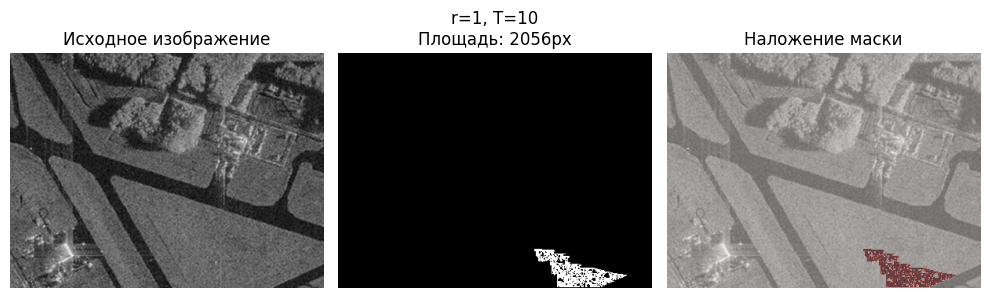


Тестирование 2/4: r=2, T=20


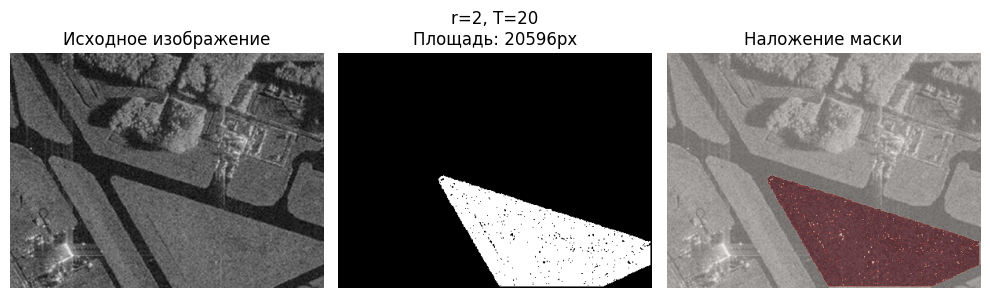


Тестирование 3/4: r=2, T=30


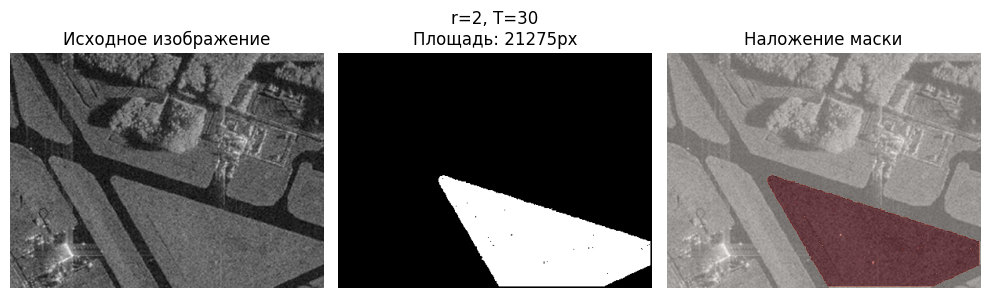


Тестирование 4/4: r=2, T=35


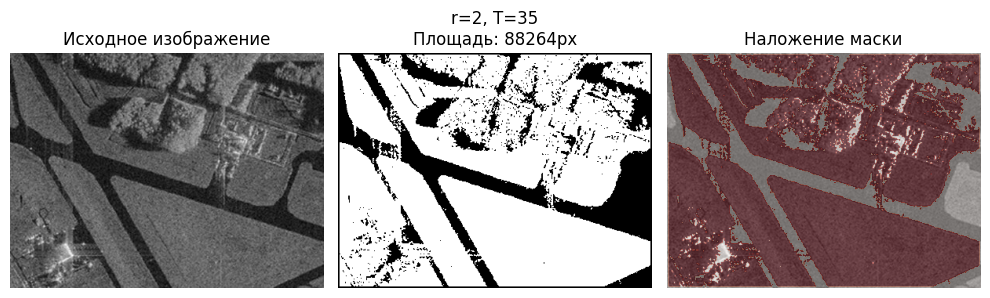

In [8]:
resutls = quick_visual_test()

### 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [9]:
import math
def homo_average(img, mask, point, T):
    av_val = np.mean(img[mask > 0])                                                    
    return abs(av_val - img[point]) <= T

In [10]:
# median criteria
def homo_median(img, mask, point, T):
    region_pixels = img[mask > 0]
    if len(region_pixels) == 0:
        return True
    median_val = np.median(region_pixels)
    return abs(median_val - img[point]) <= T
# разница между соседними пикселями (4 связность)
def homo_neighbor_diff_4(img, mask, point, T):
    y, x = point
    
    neighbors = []
    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        ny, nx = y + dy, x + dx
        if 0 <= ny < img.shape[0] and 0 <= nx < img.shape[1] and mask[ny, nx] > 0:
            neighbors.append(img[ny, nx])
    
    if not neighbors:
        return True
    
    max_diff = max([abs(img[point] - neighbor_val) for neighbor_val in neighbors])
    return max_diff <= T

# разница между соседними пикселями (8 связность)
def homo_neighbor_diff_8(img, mask, point, T):
    y, x = point
    
    neighbors = []
    for dy, dx in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, 1), (1, 0), (1, -1)]:
        ny, nx = y + dy, x + dx
        if 0 <= ny < img.shape[0] and 0 <= nx < img.shape[1] and mask[ny, nx] > 0:
            neighbors.append(img[ny, nx])
    
    if not neighbors:
        return True
    
    max_diff = max([abs(img[point] - neighbor_val) for neighbor_val in neighbors])
    return max_diff <= T


def homo_variance(img, mask, point, T):
    region_pixels = img[mask > 0]
    
    # Дисперсия текущего региона
    current_var = np.var(region_pixels)
    
    # Дисперсия с новым пикселем
    new_pixels = np.append(region_pixels, img[point])
    new_var = np.var(new_pixels)
    
    return new_var <= T

def homo_gradient(img, mask, point, T):
    y, x = point
    
    # Вычисляем градиенты с помощью оператора Собеля
    def sobel_filter(image, axis):
        if axis == 0:
            kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        else:
            kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        
        padded = np.pad(image, 1, mode='edge')
        result = np.zeros_like(image, dtype=float)
        
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                result[i, j] = np.sum(padded[i:i+3, j:j+3] * kernel)
        
        return result
    
    grad_x = sobel_filter(img, 0)
    grad_y = sobel_filter(img, 1)
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)
    
    y_start, y_end = max(0, y-1), min(img.shape[0], y+2)
    x_start, x_end = max(0, x-1), min(img.shape[1], x+2)
    
    local_grad = gradient_mag[y_start:y_end, x_start:x_end]
    
    if local_grad.size == 0:
        return True
    
    return np.max(local_grad) <= T

# критерий гистограммы (регион должен иметь не более T_peaks значительных пиков)
def homo_histogram(img, mask, point, T_peaks):
    region_pixels = img[mask > 0]

    hist, bins = np.histogram(region_pixels, bins=32, range=(0, 255))
    
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(hist, height=np.max(hist)*0.1)  # Пики выше 10% от максимума
    
    new_value = img[point]
    new_bin = np.digitize([new_value], bins)[0] - 1
    new_bin = max(0, min(new_bin, len(hist)-1))
    
    if hist[new_bin] > 0:
        return len(peaks) <= T_peaks
    else:
        return len(peaks) < T_peaks

In [11]:
def compare_homogeneity_criteria(image, seed_point, criteria_dict, r=1, T_values=None):
    if T_values is None:
        T_values = [10, 15, 20, 25, 30]
    
    results = {}
    
    for criterion_name, criterion_func in criteria_dict.items():
        print(f"Тестирование критерия: {criterion_name}")
        criterion_results = []
        
        for T in T_values:
            try:
                mask = region_growing(image, seed_point, criterion_func, r, T)
                area = np.sum(mask > 0)
                criterion_results.append((T, mask, area))
            except Exception as e:
                print(f"Ошибка для T={T}: {e}")
                criterion_results.append((T, None, 0))
        
        results[criterion_name] = criterion_results
    
    visualize_criteria_comparison(image, results, criteria_dict)
    
    return results

def visualize_criteria_comparison(image, results, criteria_dict):
    n_criteria = len(results)
    n_T = len(next(iter(results.values())))
    
    fig, axes = plt.subplots(n_criteria, n_T + 1, figsize=(4*(n_T + 1), 4*n_criteria))
    
    if n_criteria == 1:
        axes = [axes]
    
    for i, (criterion_name, criterion_results) in enumerate(results.items()):

        axes[i][0].imshow(image, cmap='gray')
        axes[i][0].set_title(f'{criterion_name}\nИсходное')
        axes[i][0].axis('off')
        
        for j, (T, mask, area) in enumerate(criterion_results):
            if mask is not None:
                axes[i][j+1].imshow(mask, cmap='gray')
                axes[i][j+1].set_title(f'T={T}\nArea: {area}')
            else:
                axes[i][j+1].text(0.5, 0.5, 'Error', ha='center', va='center')
            axes[i][j+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    for criterion_name, criterion_results in results.items():
        T_values = [r[0] for r in criterion_results]
        areas = [r[2] for r in criterion_results]
        plt.plot(T_values, areas, 'o-', label=criterion_name, linewidth=2, markersize=8)
    
    plt.xlabel('Порог T')
    plt.ylabel('Площадь региона')
    plt.title('Зависимость площади региона от порога T')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Тестирование критерия: Среднее значение
Ошибка для T=25: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Ошибка для T=30: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Тестирование критерия: Разница с соседями(4 связность)
Ошибка для T=25: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Ошибка для T=30: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Тестирование критерия: Разница с соседями(8 связность)
Ошибка для T=25: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Ошибка для T=30: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Тестирование критерия: Дисперсия
Тестирование критерия: Медиана
Ошибка для T=25: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Ошибка для T=30: The tr

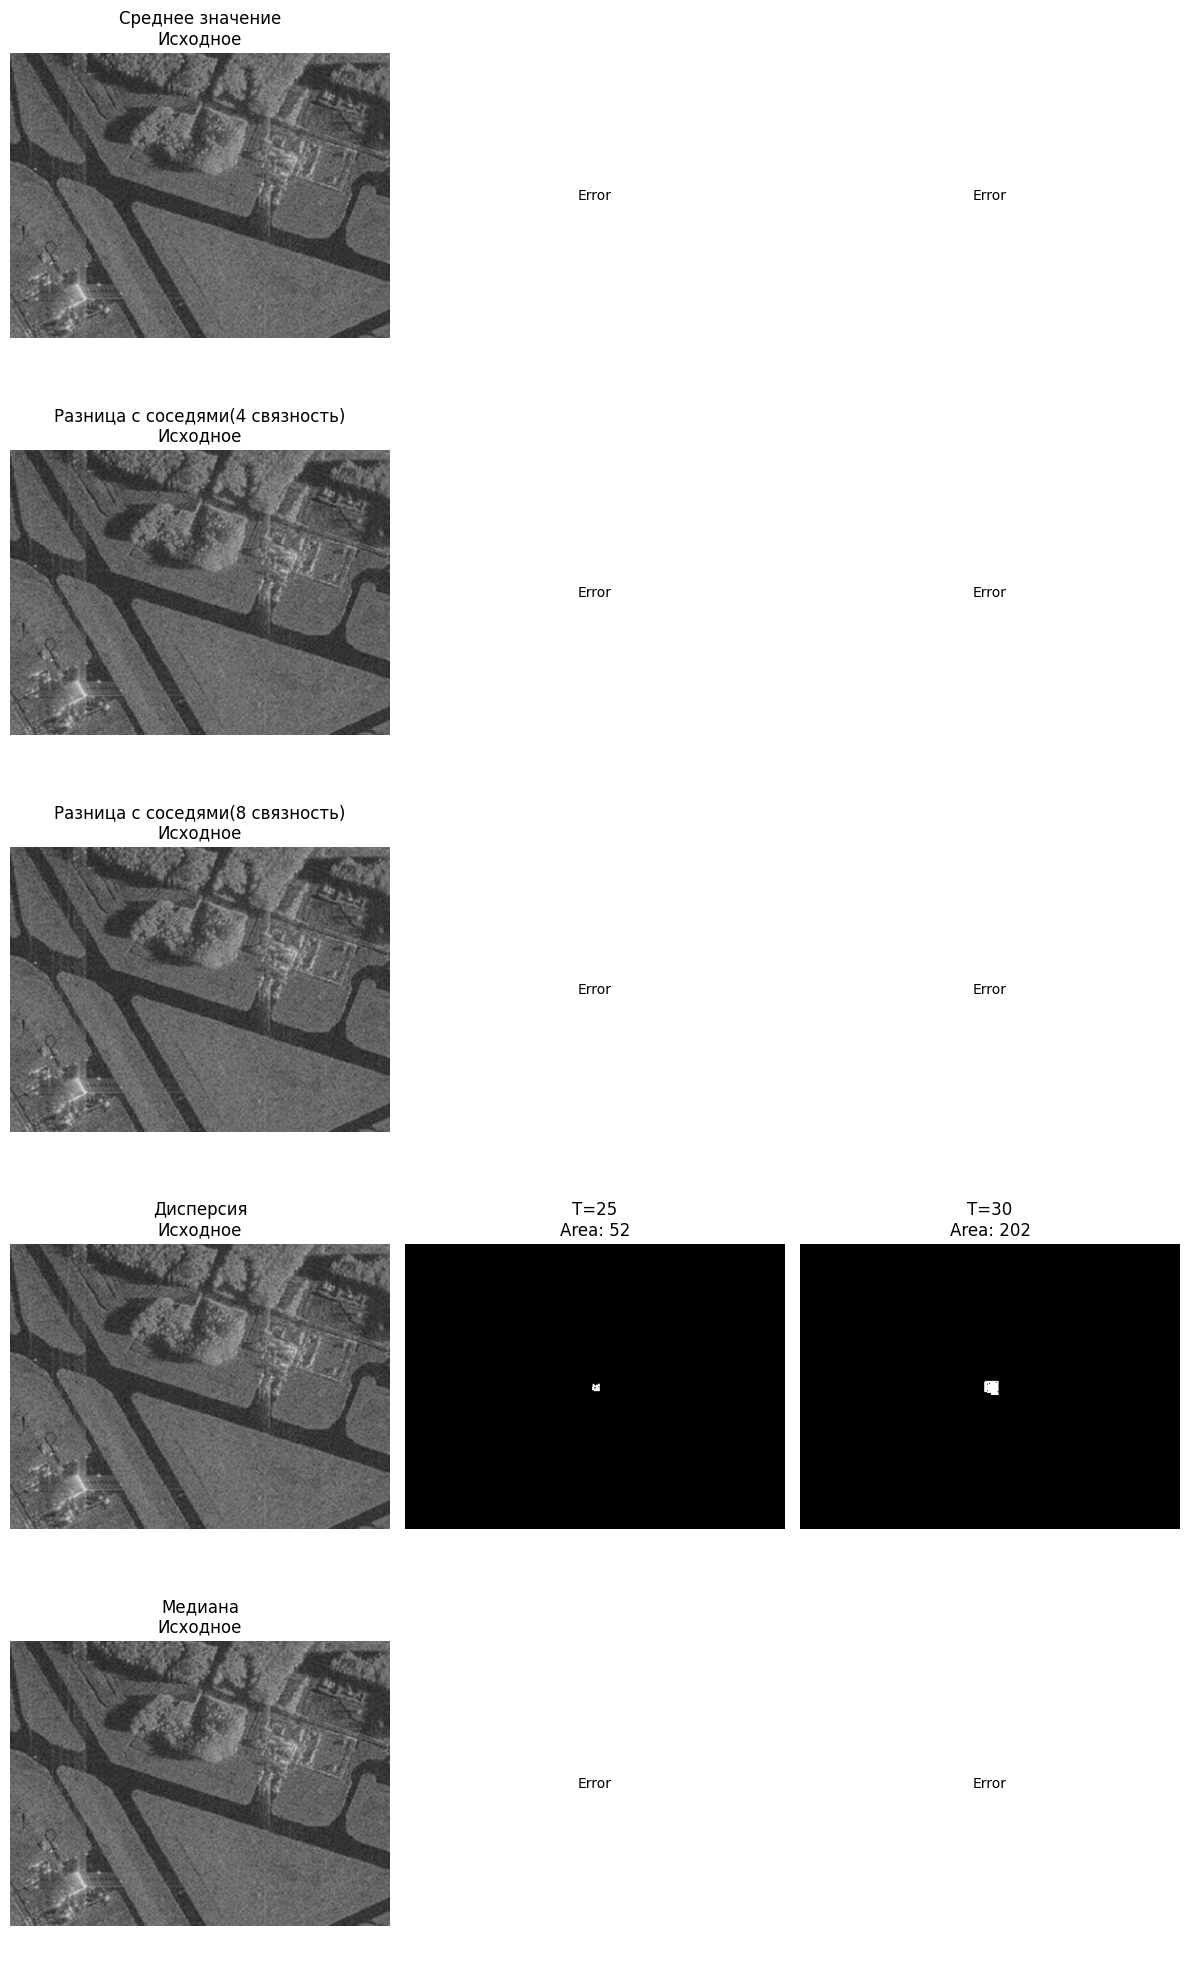

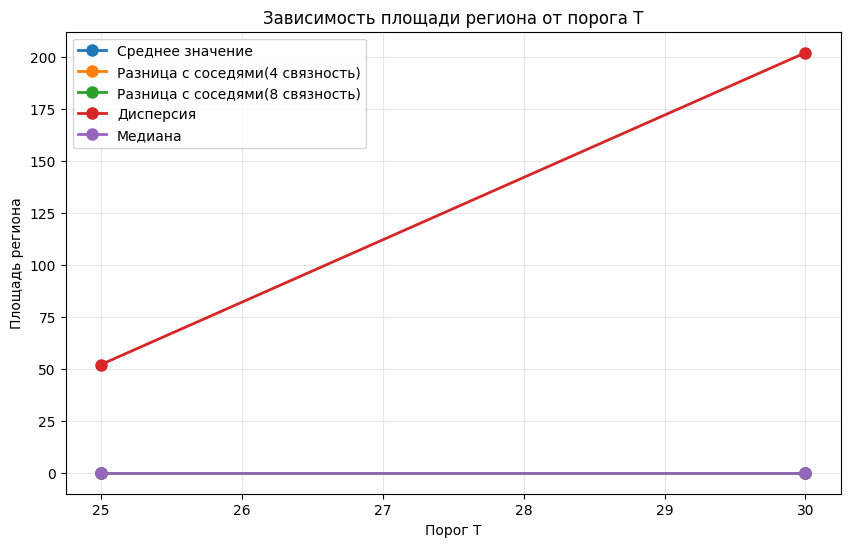

In [12]:
criteria_dict = {
    'Среднее значение': homo_average,
    'Разница с соседями(4 связность)': homo_neighbor_diff_4,
    'Разница с соседями(8 связность)': homo_neighbor_diff_8,
    'Дисперсия': homo_variance,
    'Медиана': homo_median,
}
seed_point = (150, 200)
T_values = [25, 30]
r = 4
results = compare_homogeneity_criteria(image, seed_point, criteria_dict, r, T_values)

3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.